In [3]:
# Load libraries
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.exceptions import UndefinedMetricWarning
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn import datasets
from sklearn.model_selection import RepeatedKFold, GridSearchCV
from sklearn import svm
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report, precision_score, f1_score,
    precision_recall_curve, average_precision_score,
    roc_auc_score, roc_curve, auc, ConfusionMatrixDisplay, RocCurveDisplay
   )

import xgboost as xgb
from xgboost import XGBClassifier

import tensorflow as tf

from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.metrics import AUC

import warnings

import holoviews as hv

from datetime import datetime

from xgboost import XGBRFClassifier

import os

import pickle

pd.set_option('display.float', '{:.2f}'.format)
pd.set_option('display.max_columns', 20)
pd.set_option('display.max_rows', 10)

In [14]:
df=pd.read_csv('/content/lending-club-loan_ML.csv',low_memory=False)

In [9]:
def save_score(true, pred, model_name, train=True, auc_roc=None):
    timestamp = datetime.now().strftime('%Y%m')
    file_name = f"{model_name}_TestResults_{timestamp}.csv"

    clf_report = classification_report(true, pred, output_dict=True)
    accuracy = accuracy_score(true, pred) * 100
    roc_auc = roc_auc_score(true, pred) * 100
    confusion = confusion_matrix(true, pred)

    if auc_roc is not None:
        result_df = pd.DataFrame({
            'Set': ['Train' if train else 'Test'],
            'Accuracy': [accuracy],
            'AUC-ROC': [roc_auc],
            'Classification Report': [clf_report],
            'Confusion Matrix': [confusion.tolist()]
        })
    else:
        result_df = pd.DataFrame({
            'Set': ['Train' if train else 'Test'],
            'Accuracy': [accuracy],
            'AUC-ROC': [roc_auc],
            'Classification Report': [clf_report],
            'Confusion Matrix': [confusion.tolist()]
        })

    current_dir = os.getcwd()
    pruebas_dir = os.path.join(current_dir, 'Pruebas')
    os.makedirs(pruebas_dir, exist_ok=True)

    # Unir la ruta del directorio 'pruebas' con el nombre del archivo CSV
    file_path = os.path.join(pruebas_dir, file_name)

    result_df.to_csv(file_path, index=False)

In [10]:
def print_score(true, pred, model_name, train=True):
    if train:
        clf_report = pd.DataFrame(classification_report(true, pred, output_dict=True))
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(true, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(true, pred)}\n")
    else:
        clf_report = pd.DataFrame(classification_report(true, pred, output_dict=True))
        print("Test Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(true, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(true, pred)}\n")

In [11]:
def plot_confusion_matrix(model, X_test, y_test, model_name):
    # Predicciones del modelo
    preds = model.predict(X_test)

    # Matriz de confusión
    cm = confusion_matrix(y_test, preds)
    tn, fp, fn, tp = cm.ravel()

    # Configurar el gráfico
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=['Pred Neg', 'Pred Pos'], yticklabels=['True Neg', 'True Pos'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()

    # Calcular porcentajes
    total = tn + fp + fn + tp
    accuracy = (tp + tn) / total * 100
    error_rate = (fp + fn) / total * 100
    precision = tp / (tp + fp) * 100 if (tp + fp) != 0 else 0
    recall = tp / (tp + fn) * 100 if (tp + fn) != 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

    # Calcular total de positivos y negativos con sus porcentajes
    total_correct = tp + tn
    total_errors = fp + fn
    percent_correct = total_correct / total * 100
    percent_errors = total_errors / total * 100

    # Mostrar resultados
    print(f"\nTotal Correct: {total_correct} ({percent_correct:.2f}%)")
    print('--'*30)
    print(f"True Positives (TP): {tp} ({tp/total*100:.2f}%)")
    print(f"True Negatives (TN): {tn} ({tn/total*100:.2f}%)")

    print(f"\nTotal Errors: {total_errors} ({percent_errors:.2f}%)")
    print('--'*30)
    print(f"False Positives (FP): {fp} ({fp/total*100:.2f}%)")
    print(f"False Negatives (FN): {fn} ({fn/total*100:.2f}%)")

In [12]:
def plot_roc_pr_curves(model, X_test, y_test, model_name):
    # Curva ROC
    y_test_probs = model.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_test_probs)
    roc_auc = roc_auc_score(y_test, y_test_probs)

    # Curva P-R
    precision, recall, _ = precision_recall_curve(y_test, y_test_probs)

    # Crear la figura con dos subgráficos
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    # Graficar Curva ROC
    ax1.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (AUC = {roc_auc:.2f})')
    ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guessing')
    ax1.set_xlim([0.0, 1.0])
    ax1.set_ylim([0.0, 1.05])
    ax1.set_xlabel('Tasa de Falsos Positivos')
    ax1.set_ylabel('Tasa de Verdaderos Positivos')
    ax1.set_title(f'Curva ROC - {model_name}')
    ax1.legend(loc='lower right')

    # Graficar Curva P-R
    ax2.plot(recall, precision, color='darkorange', lw=2, label='P-R curve')
    ax2.set_xlabel('Recall')
    ax2.set_ylabel('Precision')
    ax2.set_title('Precision-Recall Curve')
    ax2.legend()

    plt.tight_layout()
    plt.show()

Accuracy promedio en validación cruzada para K-Nearest Neighbors: 0.8658975979772439
Accuracy después de PCA para K-Nearest Neighbors: 0.8701807609657439
Mejores parámetros encontrados para K-Nearest Neighbors (búsqueda aleatoria): {'weights': 'uniform', 'p': 2, 'n_neighbors': 9}


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


Train Result:
Accuracy Score: 88.98%
_______________________________________________
CLASSIFICATION REPORT:
                0        1  accuracy  macro avg  weighted avg
precision    0.91     0.89      0.89       0.90          0.89
recall       0.49     0.99      0.89       0.74          0.89
f1-score     0.63     0.94      0.89       0.78          0.88
support   6198.00 25442.00      0.89   31640.00      31640.00
_______________________________________________
Confusion Matrix: 
 [[ 3017  3181]
 [  307 25135]]

Test Result:
Accuracy Score: 79.71%
_______________________________________________
CLASSIFICATION REPORT:
                0       1  accuracy  macro avg  weighted avg
precision    0.28    0.81      0.80       0.54          0.71
recall       0.04    0.98      0.80       0.51          0.80
f1-score     0.06    0.89      0.80       0.47          0.73
support   1518.00 6393.00      0.80    7911.00       7911.00
_______________________________________________
Confusion Matrix: 
 [[

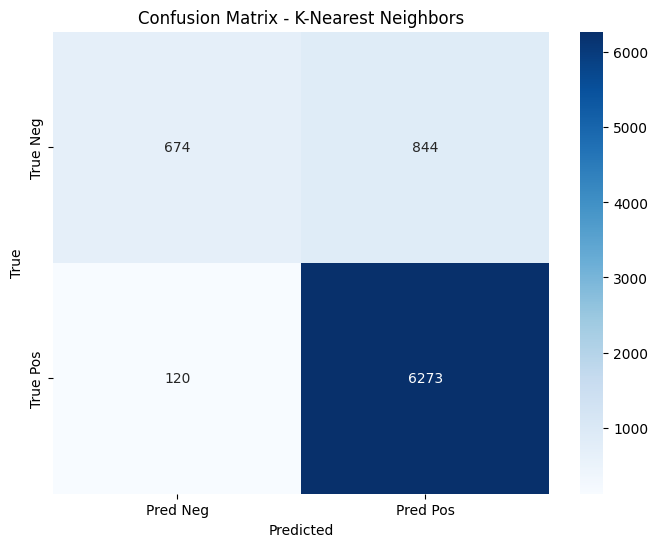


Total Correct: 6947 (87.81%)
------------------------------------------------------------
True Positives (TP): 6273 (79.29%)
True Negatives (TN): 674 (8.52%)

Total Errors: 964 (12.19%)
------------------------------------------------------------
False Positives (FP): 844 (10.67%)
False Negatives (FN): 120 (1.52%)


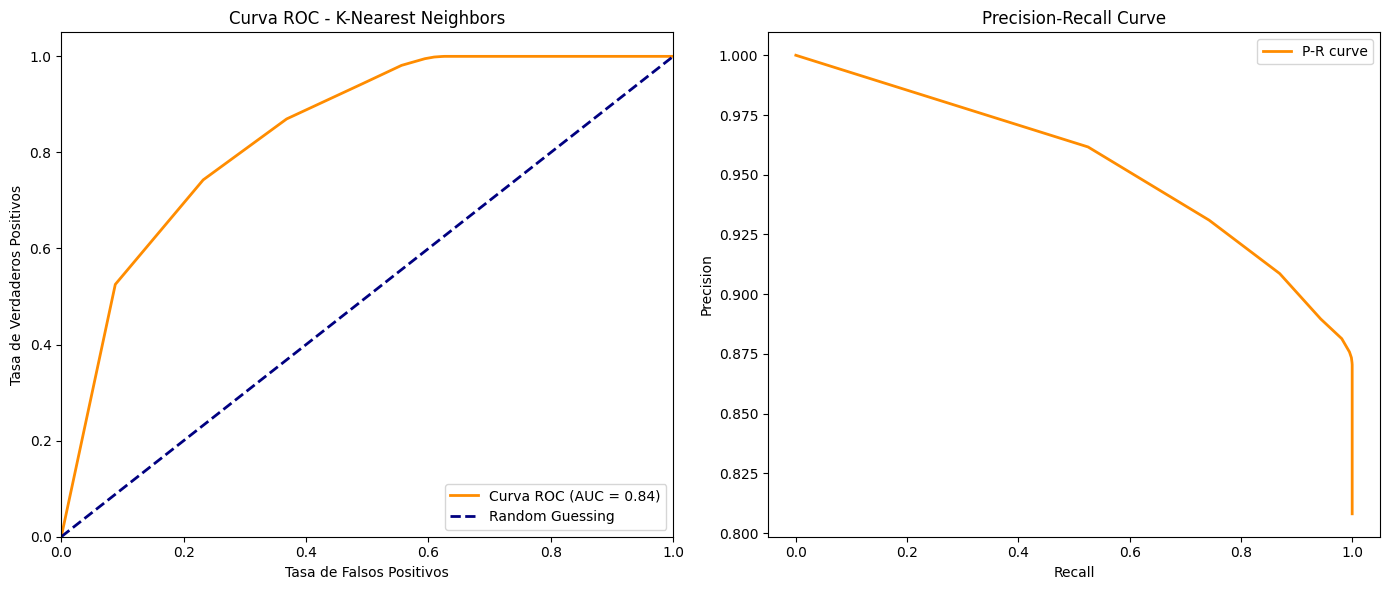

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
import numpy as np
import pandas as pd

# Assuming you have already loaded your dataset into df

# Definir la variable objetivo y las características
target = 'loan_status'
X = df.drop(columns=[target])
y = df[target]

# División de datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Identificar columnas de tipo 'object'
object_columns_train = X_train.select_dtypes(include='object').columns
object_columns_test = X_test.select_dtypes(include='object').columns

# Tratar columnas de tipo 'object' en conjunto de entrenamiento
if not object_columns_train.empty:
    X_train = pd.get_dummies(X_train, columns=object_columns_train)

# Tratar columnas de tipo 'object' en conjunto de prueba
if not object_columns_test.empty:
    X_test = pd.get_dummies(X_test, columns=object_columns_test)

# Asegurarse de que ambas versiones (entrenamiento y prueba) tengan las mismas columnas
X_train, X_test = X_train.align(X_test, join='outer', axis=1, fill_value=0)

# Estandarización de las características
scaler_knn = StandardScaler()
X_train_std_knn = scaler_knn.fit_transform(X_train)
X_test_std_knn = scaler_knn.transform(X_test)

# Validación cruzada con StratifiedKFold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Inicializar el modelo K-Nearest Neighbors
knn_model = KNeighborsClassifier()

# Realizar validación cruzada
cv_results_knn = cross_val_score(knn_model, X_train_std_knn, y_train, cv=cv, scoring='accuracy')

# Imprimir los resultados de la validación cruzada
print(f'Accuracy promedio en validación cruzada para K-Nearest Neighbors: {np.mean(cv_results_knn)}')

# Reducción de dimensionalidad mediante PCA (opcional, evalúa si es necesario)
pca_knn = PCA(n_components=0.95)  # Mantener el 95% de la varianza explicada

# Aplicar PCA a los datos de entrenamiento y prueba
X_train_pca_knn = pca_knn.fit_transform(X_train_std_knn)
X_test_pca_knn = pca_knn.transform(X_test_std_knn)

# Crear el modelo K-Nearest Neighbors después de PCA
knn_model_pca = KNeighborsClassifier()

# Entrenar el modelo en los datos transformados por PCA (opcional, evalúa si es necesario)
knn_model_pca.fit(X_train_pca_knn, y_train)

# Predicciones en el conjunto de prueba después de PCA (opcional, evalúa si es necesario)
y_pred_pca_knn = knn_model_pca.predict(X_test_pca_knn)

# Evaluación del modelo después de PCA (opcional, evalúa si es necesario)
accuracy_pca_knn = accuracy_score(y_test, y_pred_pca_knn)
print(f'Accuracy después de PCA para K-Nearest Neighbors: {accuracy_pca_knn}')

# Hiperparámetros a sintonizar (ajusta según tus necesidades)
param_dist_knn = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}

# Inicializar RandomizedSearchCV
random_search_knn = RandomizedSearchCV(knn_model, param_distributions=param_dist_knn, n_iter=10, cv=5, scoring='accuracy', random_state=42)

# Realizar la búsqueda aleatoria en los datos de entrenamiento estandarizados
random_search_knn.fit(X_train_std_knn, y_train)

# Obtener los mejores parámetros y evaluar el modelo
best_params_random_knn = random_search_knn.best_params_
print(f'Mejores parámetros encontrados para K-Nearest Neighbors (búsqueda aleatoria): {best_params_random_knn}')

# Después de obtener el mejor modelo de la búsqueda aleatoria
best_model_knn = random_search_knn.best_estimator_

# Predicciones en los conjuntos de entrenamiento y prueba con los mejores parámetros
train_preds_knn = best_model_knn.predict(X_train_std_knn)
test_preds_knn = best_model_knn.predict(X_test)

model_name_knn = 'K-Nearest Neighbors'
# Llamada a la función para imprimir métricas
print_score(y_train, train_preds_knn, model_name_knn, train=True)
print_score(y_test, test_preds_knn, model_name_knn, train=False)
# Llamada a la función para graficar la matriz de confusión
plot_confusion_matrix(best_model_knn, X_test_std_knn, y_test, model_name_knn)
# Llamada a la función para graficar las curvas ROC y P-R
plot_roc_pr_curves(best_model_knn, X_test_std_knn, y_test, model_name_knn)
# Llamada a la función para guardar los resultados en un archivo CSV
save_score(y_train, train_preds_knn, model_name_knn, train=True)
save_score(y_test, test_preds_knn, model_name_knn, train=False)

In [ ]:
# Guardar el modelo
import pickle

with open('finished_model.model', "wb") as archivo_salida:
    pickle.dump(models_gridsearch['KNN'].best_estimator_, archivo_salida)